In [134]:
import cv2
import numpy as np

def createDetector():
    detector = cv2.ORB_create(nfeatures=250, firstLevel=7)
    return detector

def getFeatures(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    detector = createDetector()
    kps, descs = detector.detectAndCompute(gray, None)
    return kps, descs, img.shape[:2][::-1]

def detectFeatures(img, train_features):
    train_kps, train_descs, shape = train_features
    # get features from input image
    kps, descs, _ = getFeatures(img)
    # check if keypoints are extracted
    if not kps:
        return None
    # now we need to find matching keypoints in two sets of descriptors (from sample image, and from current image)
    # knnMatch uses k-nearest neighbors algorithm for that
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(train_descs, descs, k=2)
    good = []
    # apply ratio test to matches of each keypoint
    # idea is if train KP have a matching KP on image, it will be much closer than next closest non-matching KP,
    # otherwise, all KPs will be almost equally far
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append([m])
    # stop if we didn't find enough matching keypoints
    if len(good) < 0.1 * len(train_kps):
        return None
    # estimate a transformation matrix which maps keypoints from train image coordinates to sample image
    src_pts = np.float32([train_kps[m[0].queryIdx].pt for m in good
                          ]).reshape(-1, 1, 2)
    dst_pts = np.float32([kps[m[0].trainIdx].pt for m in good
                          ]).reshape(-1, 1, 2)
    m, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    if m is not None:
        # apply perspective transform to train image corners to get a bounding box coordinates on a sample image
        scene_points = cv2.perspectiveTransform(np.float32([(0, 0), (0, shape[0] - 1), (shape[1] - 1, shape[0] - 1), (shape[1] - 1, 0)]).reshape(-1, 1, 2), m)
        rect = cv2.minAreaRect(scene_points)
        # check resulting rect ratio knowing we have almost square train image
        if rect[1][1] > 0 and 0.8 < (rect[1][0] / rect[1][1]) < 1.2:
            return rect
    return None

[[  0   0   0   0   0   0   0   0   1   1   1   1   1   2   2   2   3   3
    3   4   4   4   5   5   5   6   6   7   7   7   8   8   9   9  10  10
   11  11  12  12  13  13  14  14  15  15  16  17  17  18  18  19  20  20
   21  21  22  23  23  24  25  25  26  27  27  28  29  30  30  31  32  32
   33  34  35  35  36  37  38  39  39  40  41  42  43  43  44  45  46  47
   48  49  49  50  51  52  53  54  55  56  57  57  58  59  60  61  62  63
   64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
   82  83  84  85  86  87  88  89  91  92  93  94  95  96  97  98  99 101
  102 103 104 105 106 107 109 110 111 112 113 114 116 117 118 119 120 122
  123 124 125 127 128 129 130 132 133 134 135 137 138 139 140 142 143 144
  146 147 148 149 151 152 153 155 156 157 159 160 161 163 164 166 167 168
  170 171 172 174 175 177 178 179 181 182 184 185 186 188 189 191 192 194
  195 196 198 199 201 202 204 205 207 208 210 211 213 214 216 217 219 220
  222 223 225 226 228 229 231 232 234 

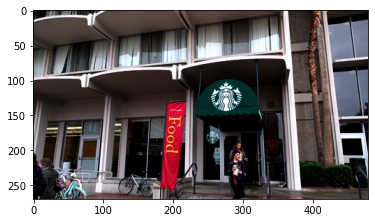

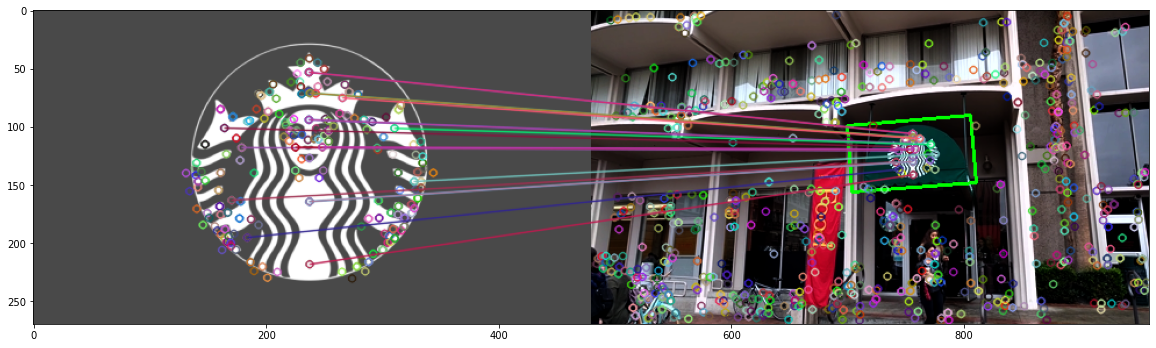

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
img1 = cv2.imread("dataset/Brand Images/starbucks_logo.bmp", cv2.IMREAD_GRAYSCALE)          # queryImage
#img2 = cv2.imread("starbucks_shot.bmp", cv2.IMREAD_COLOR) # trainImage
f = open("dataset/Videos/starbucks_snapshot.rgb", "rb")
img2 = cv2.cvtColor(
    np.moveaxis(
        np.frombuffer(
            buffer=f.read(270*480*3),
            dtype=np.uint8
        ).reshape((3, 270, 480)),
        0, -1),
    cv2.COLOR_RGB2BGR)


gamma = 1.6
lookUpTable = np.empty((1,256), np.uint8)
for i in range(256):
    lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)

img2 = cv2.LUT(img2, lookUpTable)


img3 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img3)
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)


# Initiate SIFT detector
sift = cv2.SIFT_create()#nfeatures = 1000, nOctaveLayers = 3, contrastThreshold = 0.09, edgeThreshold = 10, sigma = 1.6)
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)


# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append([m])

if len(good) < 4:
    print("bad matches")

src_pts = np.float32([kp1[m[0].queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m[0].trainIdx].pt for m in good]).reshape(-1, 1, 2)
m, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
if m is not None:
    # apply perspective transform to train image corners to get a bounding box coordinates on a sample image
    shape = img1.shape[:2]
    # map four bounding points of query image to train image based on the perspective (might not be rectangle on train image)
    scene_points = cv2.perspectiveTransform(np.float32([(0, 0), (0, shape[0] - 1), (shape[1] - 1, shape[0] - 1), (shape[1] - 1, 0)]).reshape(-1, 1, 2), m)
    # find minimum rectangle of the mapping points on train image
    rect = cv2.minAreaRect(scene_points)
    # generate four bounding points
    box = cv2.boxPoints(rect)
    # convert to integers
    box = np.int0(box)
    cv2.drawContours(img3, [box], 0, (0, 255, 0), 2)

# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img3,kp2,good,None) #,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20,10))
plt.imshow(img3)




9
((170.99398803710938, 249.70782470703125), (303.02294921875, 135.49417114257812), 9.2460298538208)


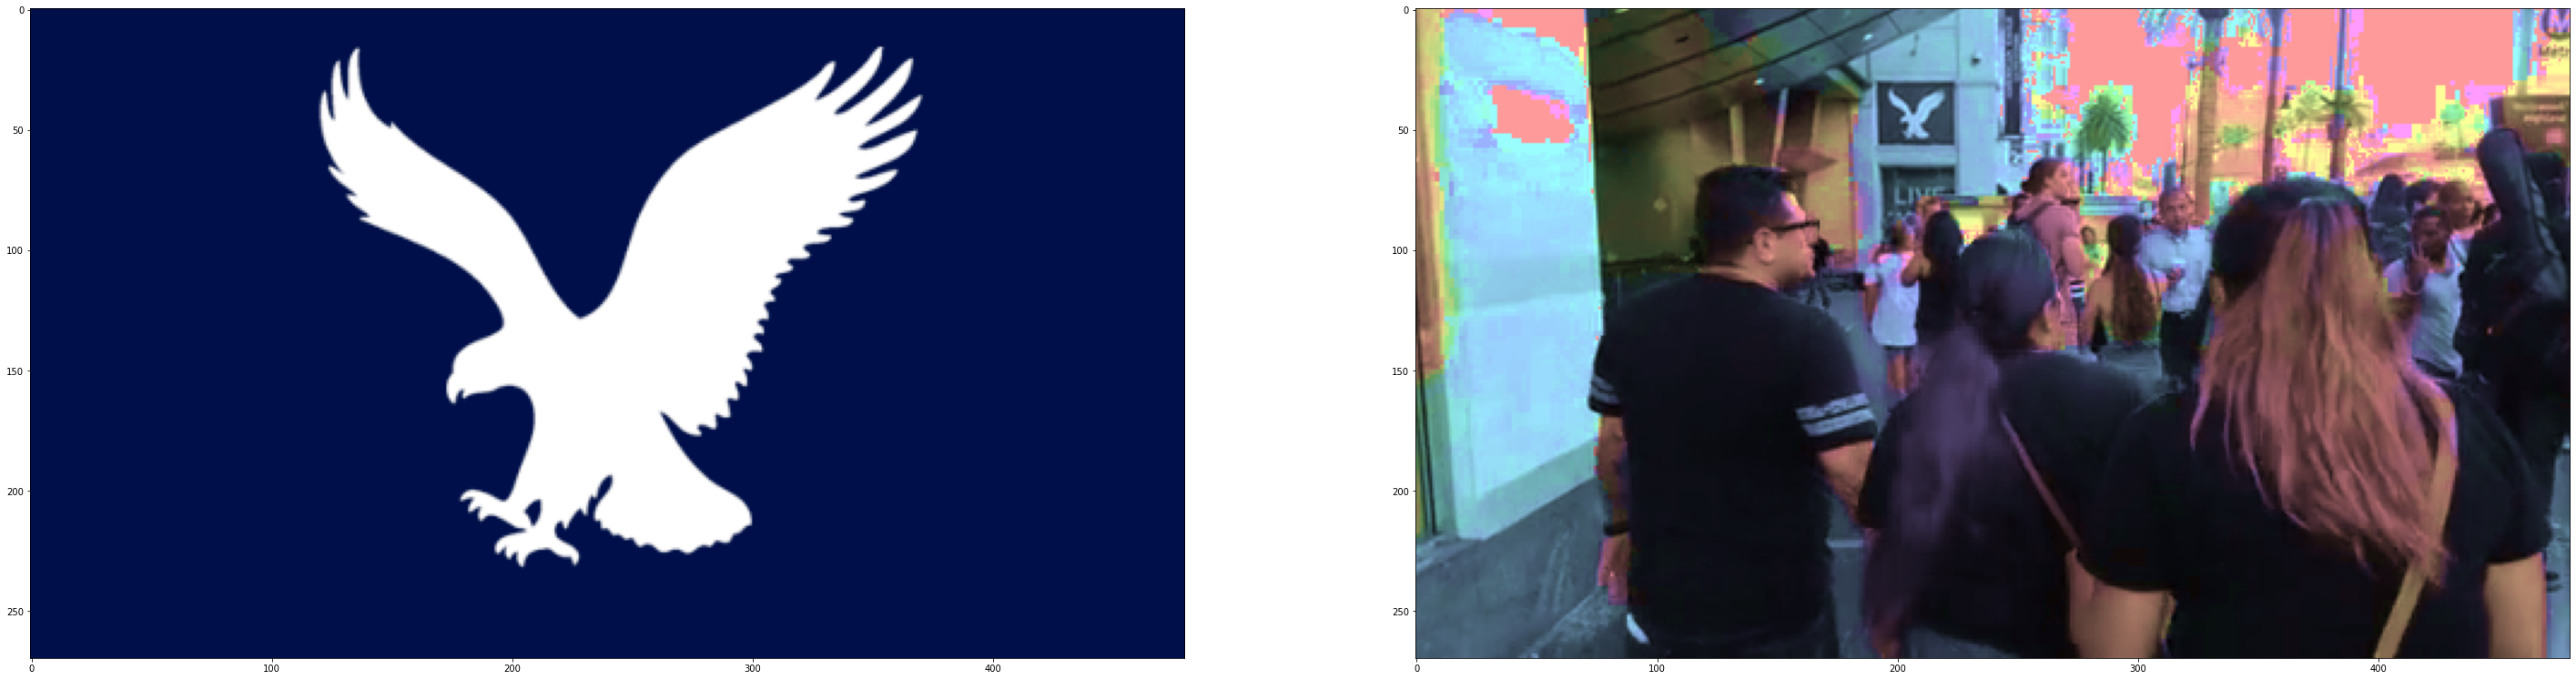

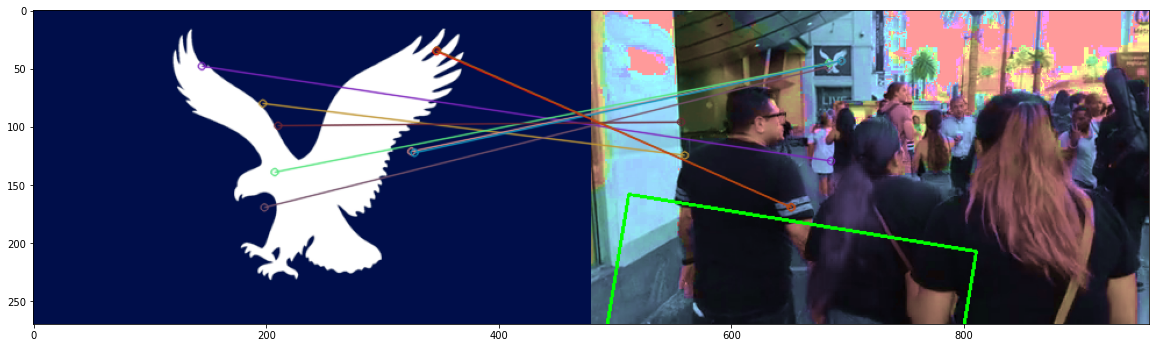

In [148]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

testcases = [
    # query, train
    ("dataset/Brand Images/subway_logo.bmp", "dataset/Videos/subway_screenshot.png"),
    ("dataset/Brand Images/starbucks_logo.bmp", "dataset/Videos/starbucks_screenshot.png"),
    ("dataset2/Brand Images/Mcdonalds_logo.bmp", "dataset2/Videos/macdonald_screenshot.png"),
    ("dataset2/Brand Images/nfl_logo.bmp", "dataset2/Videos/nfl_screenshot.png"),
    ("dataset3/Brand Images/ae_logo.bmp", "dataset3/Videos/ae_screenshot.png"),
    ("dataset3/Brand Images/hrc_logo.bmp", "dataset3/Videos/hc_screenshot.png"),
]

i1, i2 = testcases[4]
img1 = cv.imread(i1, cv.IMREAD_COLOR) # queryImage
img2 = cv.imread(i2, cv.IMREAD_COLOR) # trainImage
'''
gamma = 1.6
lookUpTable = np.array([np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255) for i in range(256)], dtype=np.uint8).reshape(1, 256)
img2 = cv.LUT(img2, lookUpTable)

_, fig = plt.subplots(1, 2, figsize=(50, 100))
fig[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
fig[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
'''
#'''
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
img1[:,:,1] = img1[:,:,1]*1 # saturation
#img1[:,:,2] = np.uint8(255) # brightness
img1[:,:,2] = img1[:,:,2]*1 # brightness
cv2.inRange(img1, (0,0,0), (255,255,255))

img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)
img2[:,:,1] = np.uint8(100) # saturation
#img2[:,:,2] = np.uint8(127) # brightness
img2[:,:,2] = img2[:,:,2]*1 # brightness

cv2.inRange(img2, (0,0,0), (255,255,255))

_, fig = plt.subplots(1, 2, figsize=(50, 100))
fig[0].imshow(cv2.cvtColor(img1, cv2.COLOR_HSV2RGB))
fig[1].imshow(cv2.cvtColor(img2, cv2.COLOR_HSV2RGB))

img1 = cv2.cvtColor(img1, cv2.COLOR_HSV2RGB)
#img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_HSV2RGB)
#img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
#'''
# Initiate SIFT detector
sift = cv.SIFT_create(nfeatures = 0, nOctaveLayers = 3, contrastThreshold = 0.09, edgeThreshold = 30, sigma = 1.6)

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

good = []
for x, y in matches:
    if x.distance < 0.7*y.distance:
        good.append([x])
#'''
print(len(good))
m = None
if len(good)>=4:
    src_pts = np.float32([kp1[m[0].queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m[0].trainIdx].pt for m in good]).reshape(-1, 1, 2)
    m, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

if m is not None:
    # apply perspective transform to train image corners to get a bounding box coordinates on a sample image
    shape = img1.shape[:2]
    # map four bounding points of query image to train image based on the perspective (might not be rectangle on train image)
    scene_points = cv2.perspectiveTransform(np.float32([(0, 0), (0, shape[0] - 1), (shape[1] - 1, shape[0] - 1), (shape[1] - 1, 0)]).reshape(-1, 1, 2), m)
    # find minimum rectangle of the mapping points on train image
    rect = cv2.minAreaRect(scene_points)
    print(rect)
    # generate four bounding points
    box = cv2.boxPoints(rect)
    # convert to integers
    box = np.int0(box)
    cv2.drawContours(img2, [box], 0, (0, 255, 0), 2)
#'''
img3 = cv.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20,10))
plt.imshow(img3)

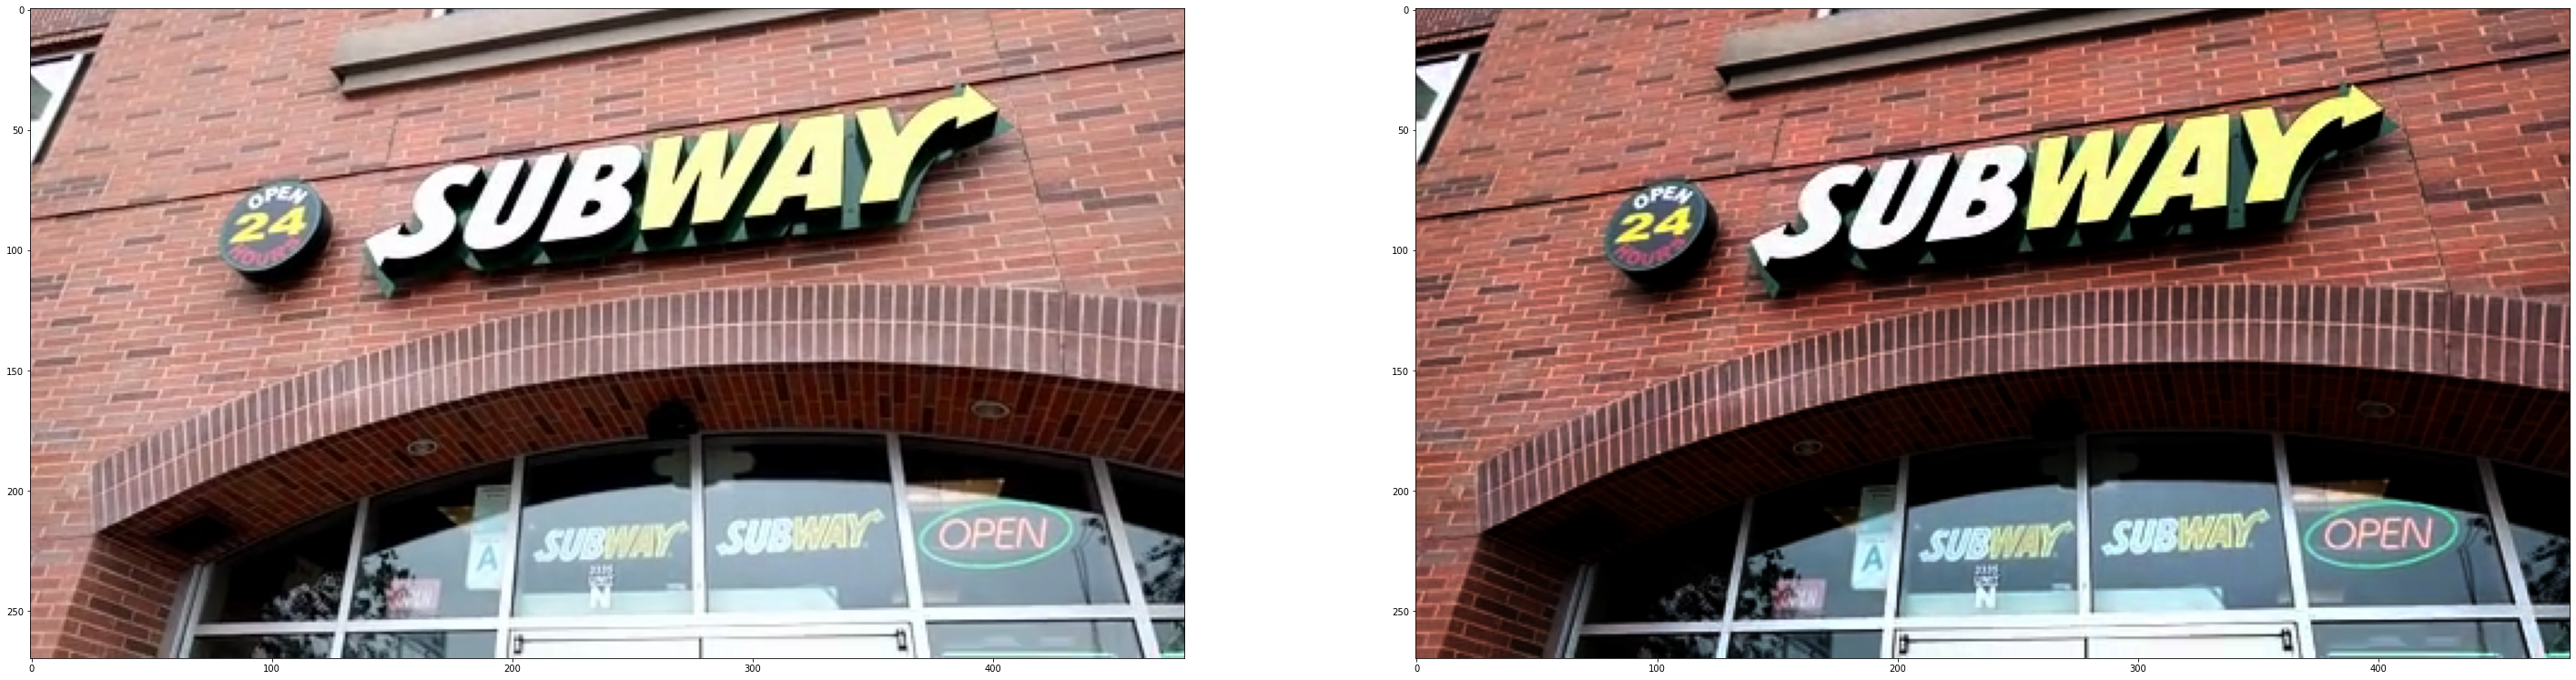

In [60]:
import cv2
import matplotlib.pyplot as plt

img2 = cv2.imread("subway_shot.bmp", cv2.IMREAD_COLOR) # trainImage

gamma = 1.75
lookUpTable = np.empty((1,256), np.uint8)
for i in range(256):
    lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    
#img2 = cv2.convertScaleAbs(img2, alpha=1.5, beta=-50)
img3 = cv.LUT(img2, lookUpTable)

img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

f, axarr = plt.subplots(1, 2, figsize=(50, 100))
axarr[0].imshow(img2)
axarr[1].imshow(img3)

number of good matches: 8


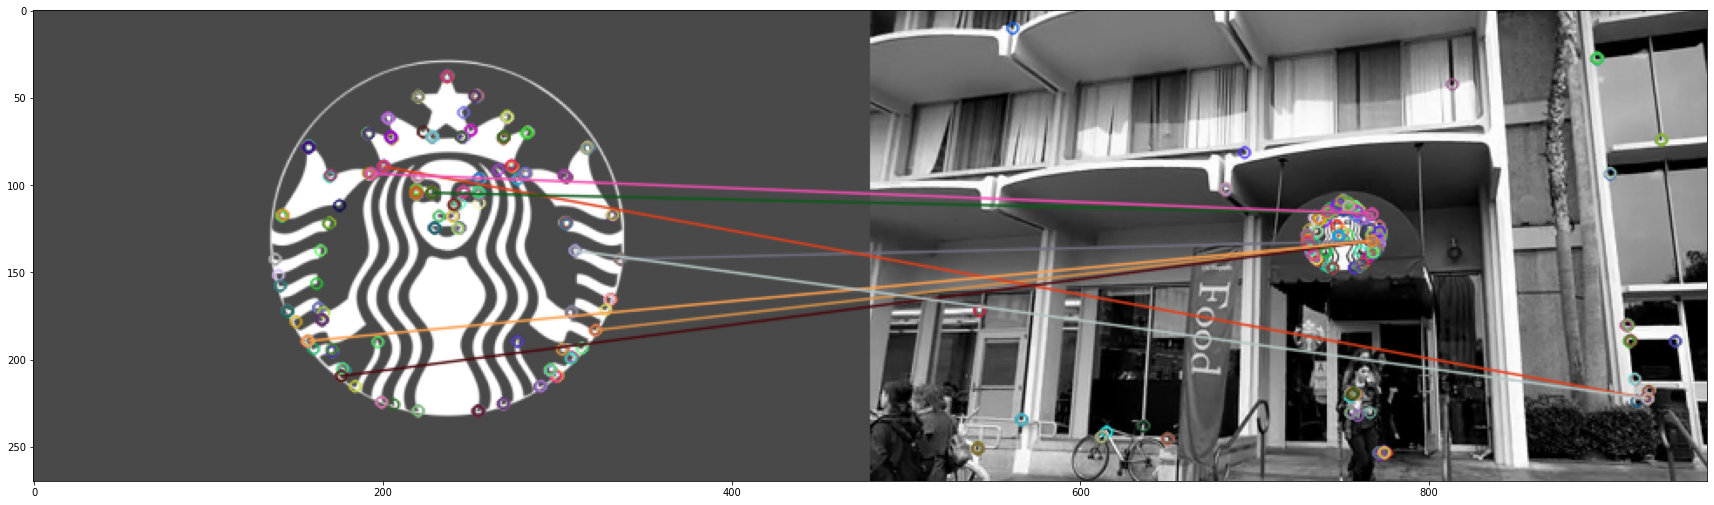

In [175]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

query_image = cv2.imread("dataset/Brand Images/starbucks_logo.bmp", cv2.IMREAD_GRAYSCALE)
train_image = cv2.imread("starbucks_shot.bmp", cv2.IMREAD_GRAYSCALE)

feature_detector = cv2.ORB_create(nfeatures=300, scaleFactor=1.25, firstLevel=7, fastThreshold = 15)
query_keypoints, query_descriptors = feature_detector.detectAndCompute(query_image, None)
train_keypoints, train_descriptors = feature_detector.detectAndCompute(train_image, None)

feature_matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = feature_matcher.knnMatch(query_descriptors, train_descriptors, k=2)

good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append([m])


result = cv2.drawMatchesKnn(query_image, query_keypoints, train_image, train_keypoints, good, None) #, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
print("number of good matches:", len(good))
plt.figure(figsize=(30,15))
plt.imshow(result)
plt.show()
